In [13]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [2]:
Lamda_LPV = 0.47; % land-use factor or packing factor

PR = 0.85;  % Performance ratio expressing the difference between performace under standard test conditions and the actual output
            % of the system due to losses from sub-optimal angles, as well as cable and inverter losses 

% Lamda_PV: PV panel efficiency corrected for atmospheric variables 
  
Lamda_panel = 0.17; % Assumed Panel effeciency under standard conditions 
            
gamma  = -0.005; % Unit: °C -1 

T_stc  = 25; % Standard test conditions temperature

c1 = 4.3;    % Unit: °C 

c2 = 0.943;  % Unit:  1

c3 = 0.028;  % Unit: °C m2 W-1

c4 = -1.528; % Unit: °C s m-1

T  = c1 + c2.*ABT + c3.*I + c4.*Wind_speed;

Lamda_PV = Lamda_panel.*(1 + gamma.*(T-T_stc));

Power_pv = I.*Lamda_LPV.*Lamda_PV.*PR; 

end 

In [3]:
c1 = 4.3
c2 = 0.943
c3 = 0.028
c4 = -1.528

T_stc = 25
gamma = -0.005
lamda_panel = 0.17

Lamda_LPV = 0.47
PR = 0.85

In [16]:
def evaluation_metric(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def n_rmse(y_true, y_pred):
    rmse_val = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse_val / (y_true.max() - y_true.min())

def test_error_percentage(score):
    return (score/18.163699578620687) * 100

def mae(y_true, y_pred):
    n = len(y_true)
    mae = sum(abs(y_true[i] - y_pred[i]) for i in range(n)) / n
    return mae

def test_rmse(y_true, y_pred):
    print(f"mae : {mae(y_true, y_pred)}")
    print(f"RMSE : {evaluation_metric(y_true, y_pred)}")
    print(f"Normalized RMSE : {n_rmse(y_true, y_pred)}")
    score = evaluation_metric(y_true, y_pred)
    print(f"Error Percentage : {test_error_percentage(score)}")

In [5]:
test = pd.read_csv('test_data_nan_wind.csv', index_col='Date')
test.fillna(-1, inplace=True)

drop_columns = ['Day', 'Precipitation(mm)',
   'Humidity(%)', 'VaporPressure(hPa)', 'DewPointTemperature(C)',
   'Sunshine(hr)', 'Snowfall(cm)',
   'SnowfallLast3Hours(cm)', 'TotalCloudCoverage(1/10)',
   'MidLowCloudCoverage(1/10)', 'CloudForm', 'LowCloud(100m)',
   'Visibility(10m)', 'GroundState(code)', 'PhenomenonNumber', 'd2m',
   't2m', 'aerosol', 'Year']
test = test.drop(columns=drop_columns)

# 1 MJ/m2 = 277.78 W/m2 (for 1 hour duration)
test['solar_radiation(W/m2)'] = test['SolarRadiation(MJ/m2)'] * 277.78
test['power'] = test['power'] / 226000

In [6]:
test['T'] = c1 + c2*test['Temperature(C)'] + c3*test['solar_radiation(W/m2)'] + c4*test['Wind_Speed']
test['Lamda_PV'] = lamda_panel*(1 + gamma*(test['T'] - T_stc))
test['Power_pv'] = test['solar_radiation(W/m2)']*Lamda_LPV*test['Lamda_PV']*PR

In [17]:
actual_power = test['power']
predicted_power = test['Power_pv']

test_rmse(actual_power, predicted_power)

mae : 5.237281946123829
RMSE : 7.247077172024367
Normalized RMSE : 0.13486820165328617
Error Percentage : 39.898684409834836


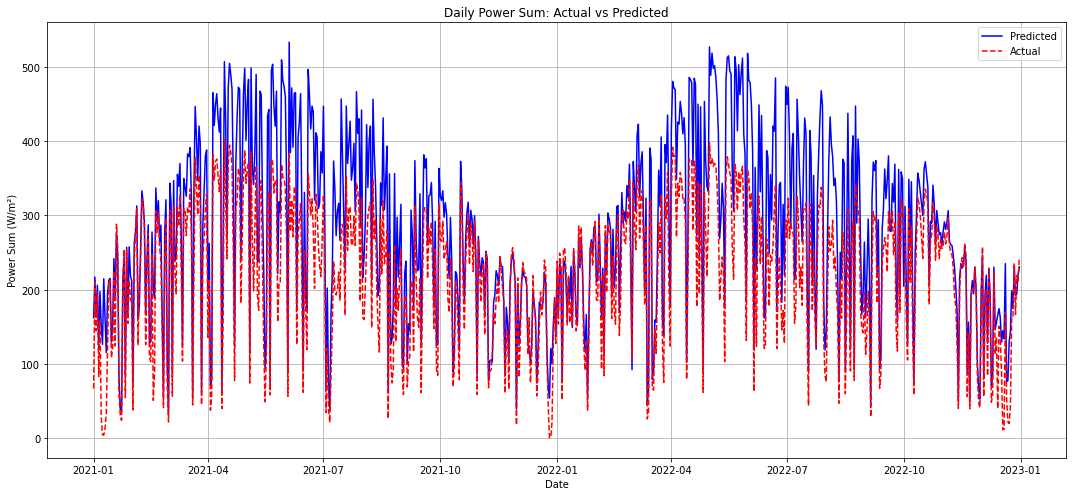

In [14]:
test['date'] = pd.to_datetime(test.index).date
actual_power.index = pd.to_datetime(actual_power.index).date

# 일별로 발전량 합계 계산
daily_predicted_sum = test.groupby('date')['Power_pv'].sum()
daily_actual_sum = actual_power.groupby(actual_power.index).sum()

# 그래프로 비교
plt.figure(figsize=(15, 7))
plt.plot(daily_predicted_sum.index, daily_predicted_sum.values, label='Predicted', color='blue')
plt.plot(daily_actual_sum.index, daily_actual_sum.values, label='Actual', color='red', linestyle='--')
plt.title('Daily Power Sum: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Power Sum (W/m²)')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

In [15]:
actual_power.mean()

18.163699578620687